# TER : Découpage de fichiers audio pour bouclage intelligent et mixage automatique

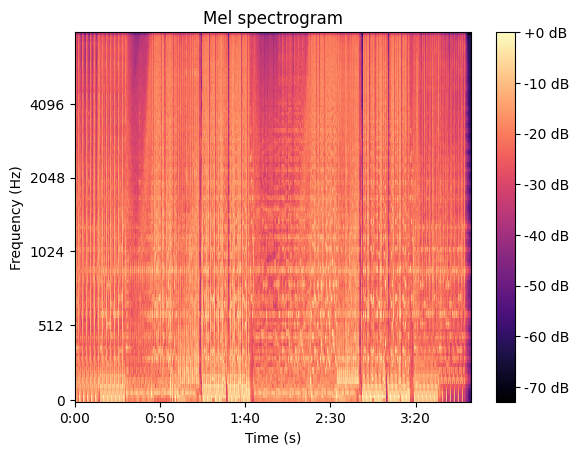

BPM : 128


In [1]:
import math
import librosa
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import shutil
import soundfile as sf
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics

# Chargement du fichier audio
musicFile = "musics/War.wav"
y,sr = librosa.load(musicFile)

# Création du mel-spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, power=1.0)

# Affichage du mel-spectrogram
fig, ax = plt.subplots(nrows=1, sharex=True)

librosa.display.specshow(librosa.power_to_db(S, ref=np.max),x_axis='time', y_axis='mel', fmax=8000)
plt.title('Mel spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(format='%+2.0f dB')

plt.show()

# Stockage des données concernant le tempo et les beats
tempo,beats = librosa.beat.beat_track(y=y, sr=sr)
beatsTime = librosa.frames_to_time(beats,sr=sr)

# Calcul du BPM
begin = beatsTime[0]
end = beatsTime[len(beatsTime)-1]

totalTime = end - begin
bpm = (len(beatsTime)-1)/(totalTime/60)

print("BPM :",round(bpm))

# Permet de faire la moyenne sur l'ensemble des données situées entre deux intervalles donnés
def beatIntervals(S,tab):
    # Initialisation à vide
    ret = []

    # Itération sur les indices des beats
    for i in range(len(tab)-1):

        # Indices de début et de fin
        firstIndex = tab[i]
        lastIndex = tab[i+1]

        # Extraction des valeurs
        indices = np.array(range(firstIndex,lastIndex))
        test = S[:,indices]

        # Calcul de la moyenne
        ret.append(np.mean(test,axis=1))
    
    # Conversion en NumPy-array et transposition
    ret = np.array(ret)
    ret = np.swapaxes(ret,1,0)    
    return ret

interBeats = beatIntervals(S,beats)

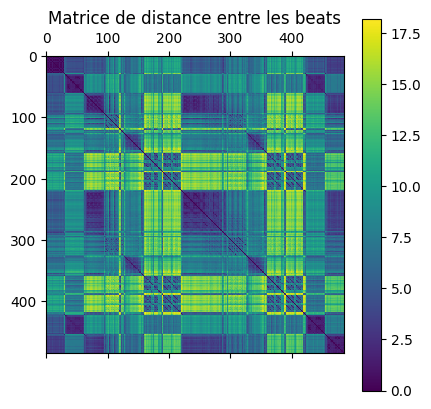

In [2]:
# Permet de calculer la matrice de distance entre les intervalles
def distanceMatrix(intervals):
    # Initialisation de la matrice carrée à 0
    mat = np.zeros((intervals.shape[1],intervals.shape[1]))
    for i in range(intervals.shape[1]):
        for j in range(i+1,intervals.shape[1]):

            # Calcul de la distance entre les intervalles i et j et remplissage de la matrice
            mat[i][j] = mat[j][i] = (sp.spatial.distance.euclidean(intervals[:,i],intervals[:,j]))
    return mat

# Affichage de la matrice de distance entre les beats
matBeats = distanceMatrix(interBeats)
plt.matshow(matBeats)
plt.title("Matrice de distance entre les beats")
plt.colorbar()
plt.show()

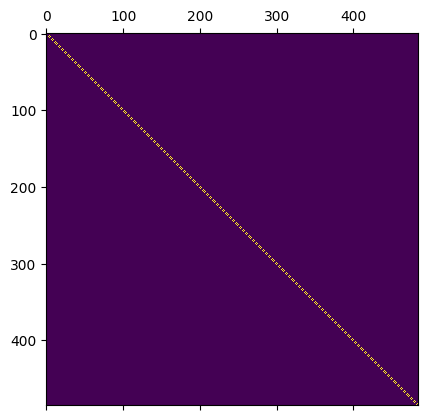

In [3]:
# Permet de construire la matrice de connectivité entre les beats
def buildBeatsConnectivityMatrix(matrix):
    ret = np.zeros((matrix.shape[1],matrix.shape[1]))
    for i in range(matrix.shape[1]):
        if i-1 >= 0:
            ret[i][i-1] = 1
        if i+1 < matrix.shape[1]:
            ret[i][i+1] = 1
    return ret

# Affichage de la matrice de connectivité
connectBeats = buildBeatsConnectivityMatrix(matBeats)
plt.matshow(connectBeats)
plt.show()

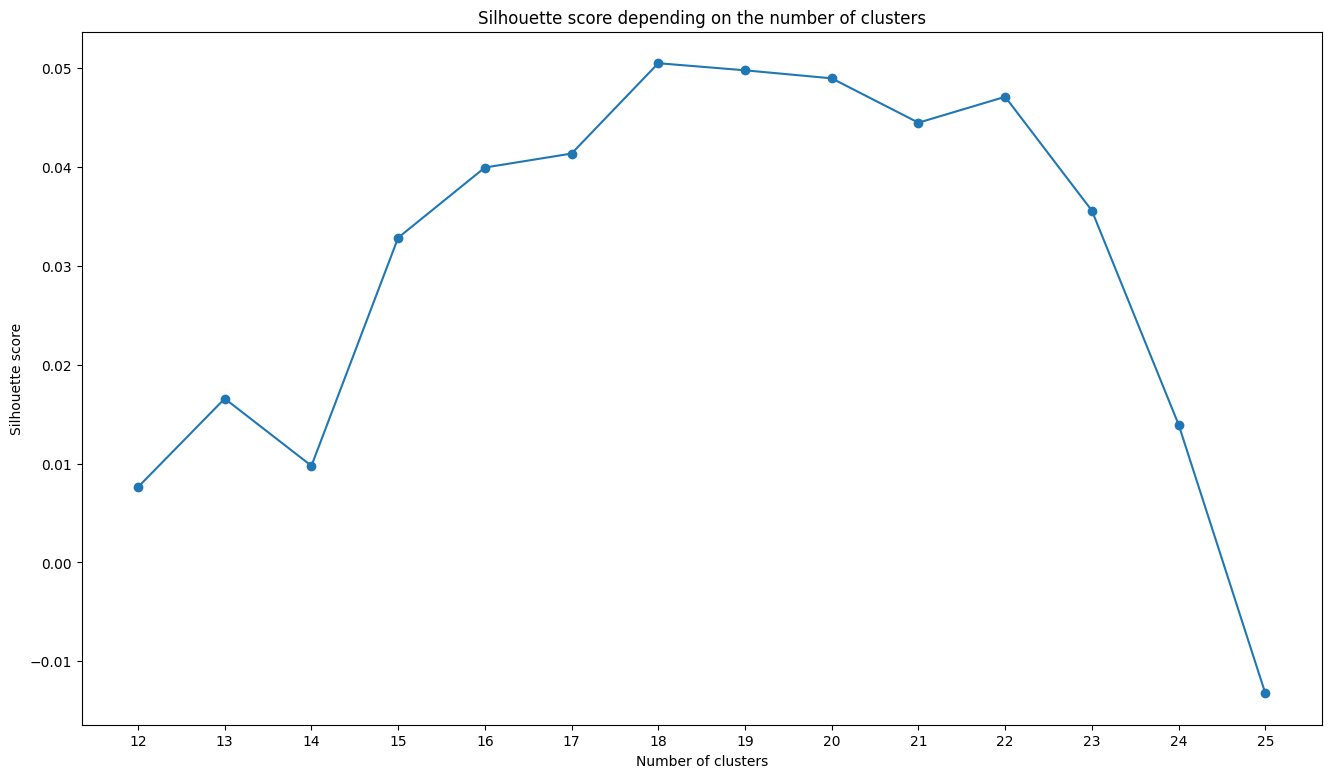

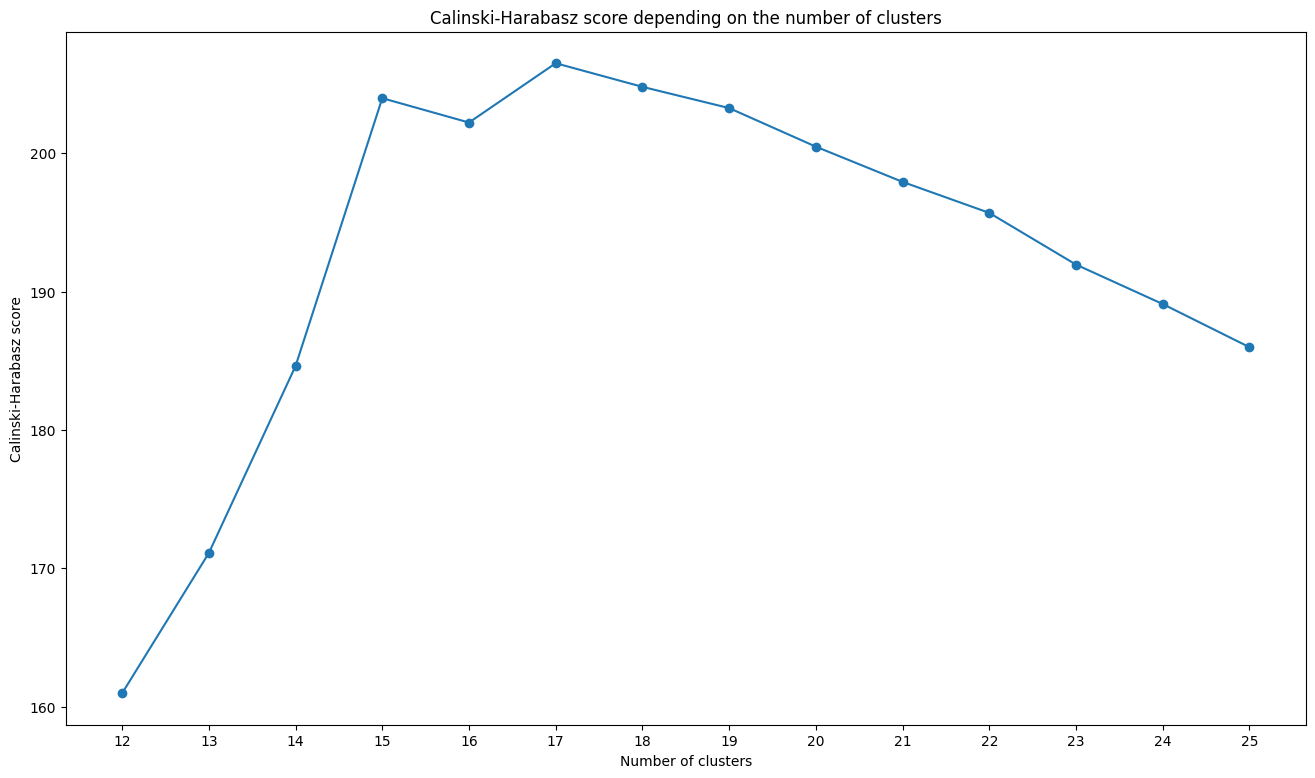

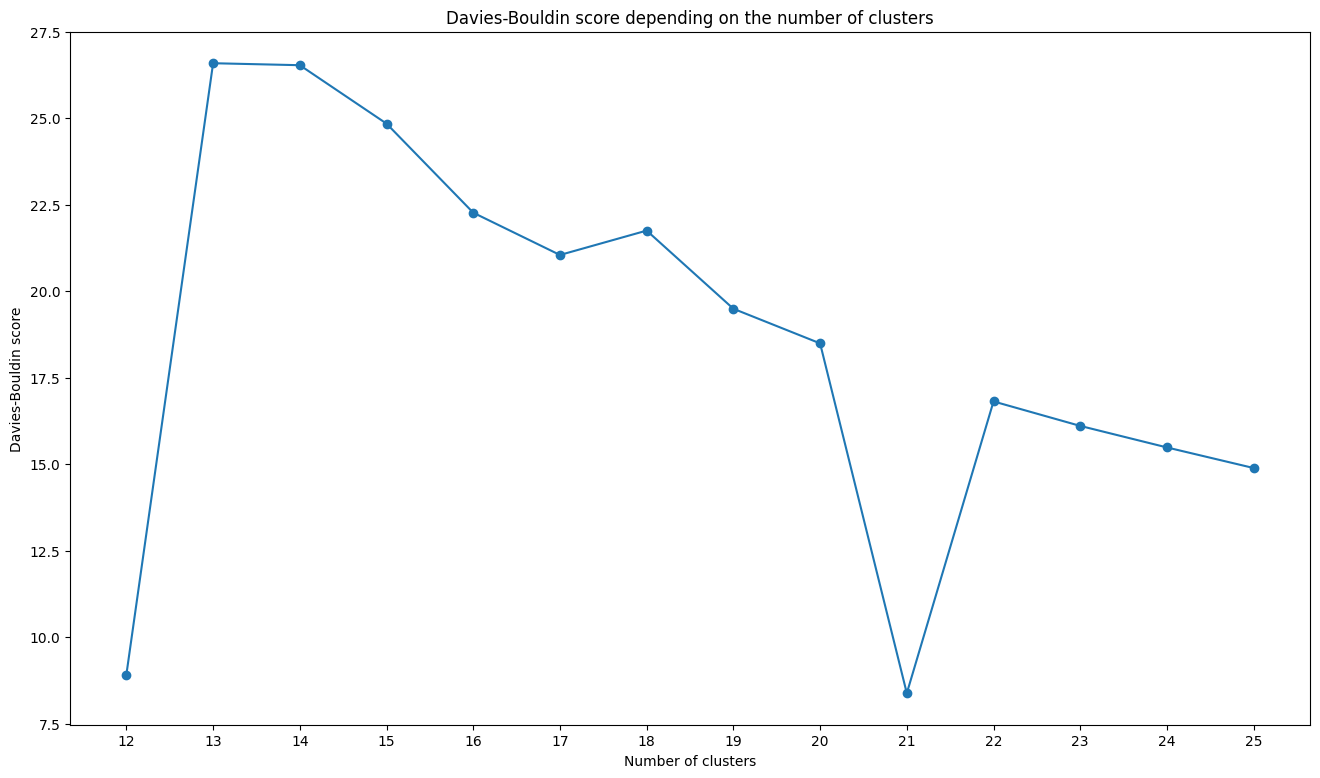

In [4]:
# Permet de calculer les scores de Silhouette Coefficient, Calinski-Harabasz Index et Davies-Bouldin Index en fonction du nombre de clusters
silhouette_scores = np.empty((0))
calinski_harabasz_scores = np.empty((0))
davies_bouldin_scores = np.empty((0))
x = np.arange(12,26)

for i in x:
    clustering = AgglomerativeClustering(n_clusters=i,connectivity=buildBeatsConnectivityMatrix(connectBeats),metric='euclidean',linkage='ward',compute_full_tree=True)
    model = clustering.fit_predict(matBeats)
    labels = clustering.labels_

    silhouette_score = metrics.silhouette_score(matBeats, labels, metric='euclidean')
    calinski_harabasz_score = metrics.calinski_harabasz_score(matBeats, labels)
    davies_bouldin_score = metrics.davies_bouldin_score(matBeats, labels)

    silhouette_scores = np.append(silhouette_scores,silhouette_score)
    calinski_harabasz_scores = np.append(calinski_harabasz_scores,calinski_harabasz_score)
    davies_bouldin_scores = np.append(davies_bouldin_scores,davies_bouldin_score)

plt.figure(figsize=(16,9))
plt.xticks(x)
plt.plot(x,silhouette_scores,'-o')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.title("Silhouette score depending on the number of clusters")
plt.show()

plt.figure(figsize=(16,9))
plt.plot(x,calinski_harabasz_scores,'-o')
plt.xticks(x)
plt.xlabel("Number of clusters")
plt.ylabel("Calinski-Harabasz score")
plt.title("Calinski-Harabasz score depending on the number of clusters")
plt.show()

plt.figure(figsize=(16,9))
plt.plot(x,davies_bouldin_scores,'-o')
plt.xticks(x)
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Bouldin score")
plt.title("Davies-Bouldin score depending on the number of clusters")
plt.show()

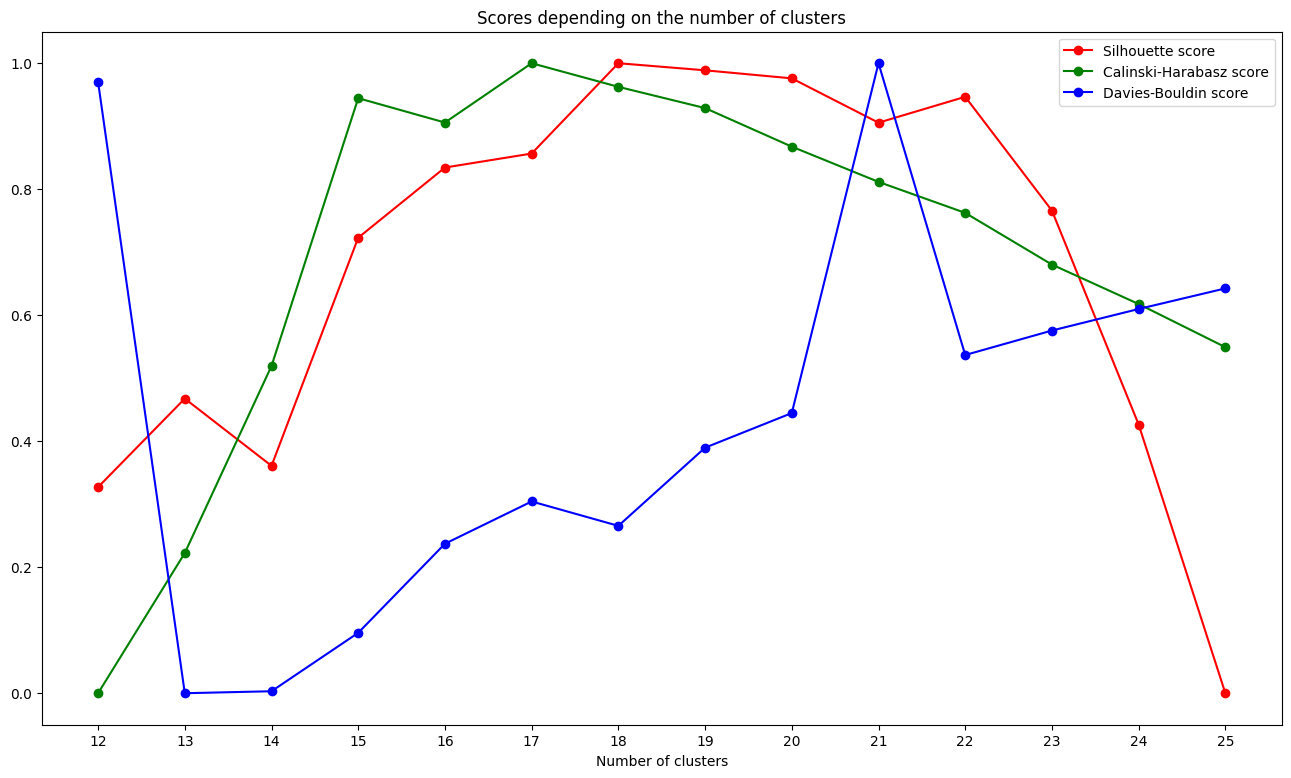

In [5]:
# Permet de créer le graphique regroupant l'ensemble des scores après normalisation
min_silhouette = np.min(silhouette_scores)
max_silhouette = np.max(silhouette_scores)
min_Calinski = np.min(calinski_harabasz_scores)
max_Calinski = np.max(calinski_harabasz_scores)
min_davies = np.min(davies_bouldin_scores)
max_davies = np.max(davies_bouldin_scores)

silhouette_scores = (silhouette_scores - min_silhouette) / (max_silhouette - min_silhouette)
calinski_harabasz_scores = (calinski_harabasz_scores - min_Calinski) / (max_Calinski - min_Calinski)
davies_bouldin_scores = (davies_bouldin_scores - min_davies) / (max_davies - min_davies)
davies_bouldin_scores = 1 - davies_bouldin_scores

plt.figure(figsize=(16,9))
plt.xticks(x)
plt.plot(x,silhouette_scores,'-o',color='red',label="Silhouette score")
plt.plot(x,calinski_harabasz_scores,'-o',color="green",label="Calinski-Harabasz score")
plt.plot(x,davies_bouldin_scores,'-o',color="blue",label="Davies-Bouldin score")
plt.legend()
plt.xlabel("Number of clusters")
plt.title("Scores depending on the number of clusters")
plt.show()

In [6]:
# Permet de classer les différents nombres de clusters en fonction des scores obtenus
def rankingBestNumberClusters(x,silhouette_scores,calinski_harabasz_scores,davies_bouldin_scores):
    sil_Ranks = np.zeros(x.shape[0])
    cal_ha_Ranks = np.zeros(x.shape[0])
    dav_bou_Ranks = np.zeros(x.shape[0])

    alt_sil = np.sort(silhouette_scores)[::-1]
    alt_cal = np.sort(calinski_harabasz_scores)[::-1]
    alt_dav = np.sort(davies_bouldin_scores)

    while alt_sil.shape[0] != 0:
        silMax = np.max(alt_sil)
        indice = np.where(silhouette_scores == silMax)[0][0]
        sil_Ranks[indice] = math.floor(x.shape[0] - alt_sil.shape[0] + 1)
        alt_sil = np.delete(alt_sil,0)

    while alt_cal.shape[0] != 0:
        calMax = np.max(alt_cal)
        indice = np.where(calinski_harabasz_scores == calMax)[0][0]
        cal_ha_Ranks[indice] = math.floor(x.shape[0] - alt_cal.shape[0] + 1)
        alt_cal = np.delete(alt_cal,0)

    while alt_dav.shape[0] != 0:
        davMin = np.min(alt_dav)
        indice = np.where(davies_bouldin_scores == davMin)[0][0]
        dav_bou_Ranks[indice] = math.floor(x.shape[0] - alt_dav.shape[0] + 1)
        alt_dav = np.delete(alt_dav,0)

    total = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        total[i] = sil_Ranks[i] + cal_ha_Ranks[i] + dav_bou_Ranks[i]

    total_Ranks = np.zeros(x.shape[0])
    copy = total.copy()

    while copy.shape[0] != 0:
        totalMin = np.min(copy)
        indice = np.where(total == totalMin)[0]
        for elt in indice:
            total_Ranks[elt] = math.floor(x.shape[0] - copy.shape[0] + 1)
        for elt in indice:
            copy = copy[copy != totalMin]

    final = np.empty((0))

    for rank in range(1,x.shape[0]+1):
        for k in range(x.shape[0]-1,-1,-1):
            if total_Ranks[k] == rank:
                final = np.append(final,x[k])

    print(final[0])

    return final[0]
    
idealClusterNb = rankingBestNumberClusters(x,silhouette_scores,calinski_harabasz_scores,davies_bouldin_scores)

18.0


In [7]:
# Permet de déterminer les clusters en fonction du nombre de clusters idéal
def determineClusters(matrix,idealClusterNb):
    clustering = AgglomerativeClustering(n_clusters=int(idealClusterNb),connectivity=matrix,metric='euclidean',linkage='ward',compute_full_tree=True)
    model = clustering.fit_predict(matBeats)

    labels = clustering.labels_

    # Minimum size of clusters
    min_cluster_size = 16

    # Calculate the size of each cluster
    cluster_sizes = np.bincount(model)

    # Order all the clusters by their minimal index
    clusters = np.argsort([np.min(np.where(model == i)[0]) for i in range(clustering.n_clusters_)])

    # Merge the two first clusters while they are smaller than the minimum size
    while cluster_sizes[clusters[0]] < min_cluster_size:
        model[model == clusters[0]] = clusters[1]
        cluster_sizes[clusters[1]] += cluster_sizes[clusters[0]]
        cluster_sizes[clusters[0]] = 0
        clusters = np.delete(clusters,0)

    # Find the clusters that are smaller than the minimum size
    small_clusters = np.where(cluster_sizes < min_cluster_size)[0]

    # Erase the labels of the small clusters which don't contain any beat
    for small_cluster in small_clusters:
        if cluster_sizes[small_cluster] == 0:
            small_clusters = np.delete(small_clusters,np.where(small_clusters == small_cluster))

    # Get the minimum index of each small cluster
    min_indices = [np.min(np.where(labels == i)[0]) for i in small_clusters]

    # Sort the small clusters in ascending order of their minimum index
    small_clusters = small_clusters[np.argsort(min_indices)]

    # For each small cluster
    for small_cluster in small_clusters:
        # Find the indices of the small cluster
        indices_small_cluster = np.where(model == small_cluster)[0]

        # Find the nearest larger cluster in terms of index proximity
        min_distance = np.inf
        nearest_larger_cluster = None
        for larger_cluster in np.where(cluster_sizes >= min_cluster_size)[0]:
            # Find the indices of the larger cluster
            indices_larger_cluster = np.where(model == larger_cluster)[0]

            if indices_larger_cluster[-1] < indices_small_cluster[0]:
                # Calculate the minimum absolute difference between the indices
                distance = np.min(np.abs(indices_small_cluster[:, None] - indices_larger_cluster))

                if distance < min_distance:
                    min_distance = distance
                    nearest_larger_cluster = larger_cluster
        # Merge the small cluster into the nearest larger cluster
        model[model == small_cluster] = nearest_larger_cluster

    cluster_sizes = np.bincount(model)

    clusters = []

    for i in range(clustering.n_clusters_+1):
        clusters.append(np.where(model == i))

    clusters = [x for x in clusters if len(x[0]) > 0]

    clusters.sort(reverse=False,key=lambda x : x[0][0])

    limits = np.zeros(len(clusters)*2)

    for i in range(len(clusters)):
        limits[2*i] = math.floor(clusters[i][0][0])
        limits[2*i+1] = math.floor(clusters[i][0][len(clusters[i][0])-1])

    limits = limits.reshape(-1,2)
    limits = np.int_(limits)

    print(limits)

    return limits

limits = determineClusters(connectBeats,idealClusterNb)

[[  0  30]
 [ 31  61]
 [ 62  94]
 [ 95 125]
 [126 158]
 [159 190]
 [191 218]
 [219 293]
 [294 324]
 [325 358]
 [359 390]
 [391 422]
 [423 453]
 [454 484]]


In [8]:
# Permet de générer les parties de la musique en fonction des clusters
def generatePartsWithClusteringBeats(tab):
    donnees,samplerate = sf.read(musicFile)
    print("Durée de la musique :",donnees.shape[0]//(60*samplerate),"minutes",(donnees.shape[0]%(samplerate*60))//(samplerate),"secondes")

    if shutil.os.path.exists("test/clustering"):
        shutil.rmtree("test/clustering")
    shutil.os.makedirs("test/clustering") 

    for i in range(len(tab)):
        beginBeat = tab[i][0]
        endBeat = tab[i][1]

        beginTime = beatsTime[beginBeat]
        endTime = beatsTime[endBeat]

        if i == 0:
            beginData = 0
        else:
            beginData = math.floor(beginTime*samplerate)+1

        if i == len(tab)-1:
            endData = len(donnees)-1
        else:
            endTime = beatsTime[endBeat+1]
            endData = math.floor(endTime*samplerate)

        print(beginData,endData)

        data = donnees[beginData:endData]
        filename = "test/clustering/part"+str(i+1)+".wav"
        sf.write(filename,data,samplerate,'PCM_16')

generatePartsWithClusteringBeats(limits)

Durée de la musique : 3 minutes 52 secondes
0 722233
722234 1419946
1419947 2162242
2162243 2859955
2859956 3601136
3601137 4321140
4321141 4951980
4951981 6639420
6639421 7332675
7332676 8101720
8101721 8821725
8821726 9541729
9541730 10239442
10239443 11164687


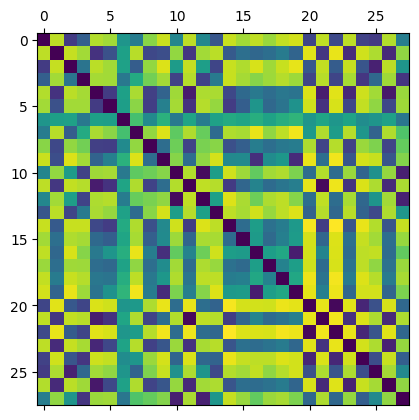

In [9]:
# Permet de créer une matrice de distances sur chaque limite de cluster sur l'ensemble de la musique
nbClusters = len(limits)

elts = []
for elt in limits:
    elts.append(S[:,beats[elt[0]]])
    elts.append(S[:,beats[elt[1]]])

elts = np.array(elts)
elts = np.swapaxes(elts,1,0)

testMatrix = distanceMatrix(elts)
plt.matshow(testMatrix)
plt.show()

In [10]:
# Permet de sélectionner les transitions potentielles
select = []
# Copie de la matrice de distances
data = np.copy(testMatrix)

# Suppression des valeurs nulles
indices = np.where(data != 0)
data = data[indices]

# Tri des valeurs
data = np.sort(data)

# Suppression des valeurs doublées
indices = np.arange(0,data.shape[0],2)
data = data[indices]

# Recherche des candidats potentiels pour la transition
for val in data:
    ### COMMENTER LA VERSION DE CODE NON SOUHAITEE CI-DESSOUS AVANT DE LANCER LE BLOCK DE CODE

    ## LIMITED VERSION
    # if len(select) < 3:
    #     for i in range(testMatrix.shape[0]):
    #         for j in range(i+1,testMatrix.shape[0]):
    #             if testMatrix[i][j] == val and np.abs(i-j) > 2 and np.abs(i-j)%2 == 1 and val/np.max(testMatrix) < 0.1:
    #                 print(val,np.max(testMatrix))
    #                 select.append([j,i])
    
    ## UNLIMITED VERSION
    for i in range(testMatrix.shape[0]):
        for j in range(i+1,testMatrix.shape[0]):
            if testMatrix[i][j] == val and np.abs(i-j) > 2 and np.abs(i-j)%2 == 1 and i%2==0 and val/np.max(testMatrix) < 0.1:
                print(val,np.max(testMatrix))
                select.append([j,i])

print(select)

2.3691999912261963 31.888765335083008
2.5380136966705322 31.888765335083008
2.5449514389038086 31.888765335083008
2.753769636154175 31.888765335083008
2.9227774143218994 31.888765335083008
2.929455280303955 31.888765335083008
[[11, 4], [21, 4], [19, 16], [27, 10], [25, 2], [27, 12]]


In [11]:
# Permet de générer les transitions et le fichier audio final
musicParts = []
tracks = []
transitions = []

if shutil.os.path.exists("test/transitions"):
    shutil.rmtree("test/transitions")
shutil.os.makedirs("test/transitions")

def createTrack(beginIndex,endIndex):
    track = np.concatenate(musicParts[beginIndex:endIndex])
    tracks.append(track)
    print("oui")
    
### A DECOMMENTER POUR GENERER L'AUDIO FINAL
for i in range(len(limits)):
    musicPart,sr = sf.read("test/clustering/part"+str(i+1)+".wav")
    musicParts.append(musicPart)

### DECOMMENTER LES FONCTIONS createTrack CI-DESSOUS POUR GENERER L'AUDIO FINAL

for i in range(len(select)):
    if i == 0:
        begin = 1
        end = select[i][0]//2+1
        transitions.append([begin,end])
        createTrack(begin,end)
        print(begin,end)
        begin = select[i][1]//2+1
    elif i != len(select)-1:
        end = select[i][0]//2+1
        transitions.append([begin,end])
        createTrack(begin,end)
        print(begin,end)
        begin = select[i][1]//2+1
    else:
        end = select[i][0]//2+1
        transitions.append([begin,end])
        createTrack(begin,end)
        print(begin,end)
        begin = select[i][1]//2+1
        end = nbClusters
        transitions.append([begin,end])
        createTrack(begin,end)
        print(begin,end)

### A DECOMMENTER POUR GENERER L'AUDIO FINAL
finalTrack = np.concatenate(tracks)
sf.write("test/transitions/track_with_transitions.wav",finalTrack,sr,"PCM_16")    

oui
1 6
oui
3 11
oui
3 10
oui
9 14
oui
6 13
oui
2 14
oui
7 14


In [12]:
# Permet de faire un étiquettage de chaque partie de la musique
def determineTags(tab):
    arr = []
    
    for i in range(len(tab)):
        beginBeat = tab[i][0]
        endBeat = tab[i][1]

        beginPart = beats[beginBeat]
        endPart = beats[endBeat+1]

        if i == 0:
            beginPart = 0

        if i == len(tab)-1:
            endPart = S.shape[1]-1

        part = S[:,beginPart:endPart]

        arr.append(np.median(part,axis=1))

    arr = np.array(arr)

    arr2 = []

    for elt in range(arr.shape[0]):
        arr2.append(np.sum(arr[elt]))

    arr2 = np.array(arr2)

    tags = []
    for i in range(len(limits)):
        tags.append("")

    indMax = np.argmax(arr2)
    tags[indMax] = "Drop"

    tags[0] = "Intro"
    tags[len(limits)-1] = "Outro"

    for i in range(len(limits)):
            if arr2[i] > 0.9*arr2[indMax] and i>1:
                tags[i] = "Drop"
            elif tags[i-1] == "Intro" and tags[i] == "" and not i>1:
                tags[i] = "Intro"

    for i in range(len(limits)-1):
        if tags[i-1] == "Drop" and tags[i+1] == 'Outro':
            tags[i] = "Outro"

    for i in range(len(limits)):
        if tags[i] == "" and tags[i+1] == "Drop":
            tags[i] = "Pré-drop"
        elif tags[i] == "":
            tags[i] = "Couplet"

    for i in range(len(limits)):
        if tags[i-2] == "Drop" and tags[i-1] == "Couplet" and tags[i] == "Couplet" and 2/3*arr2[i-2] < arr2[i-1]:
            tags[i-1] = "Drop"

    print(tags)

    return tags

tags = determineTags(limits)
        

['Intro', 'Intro', 'Couplet', 'Couplet', 'Pré-drop', 'Drop', 'Drop', 'Couplet', 'Couplet', 'Pré-drop', 'Drop', 'Drop', 'Outro', 'Outro']


[[1, 6], [3, 11], [3, 10], [9, 14], [6, 13], [2, 14], [7, 14]]


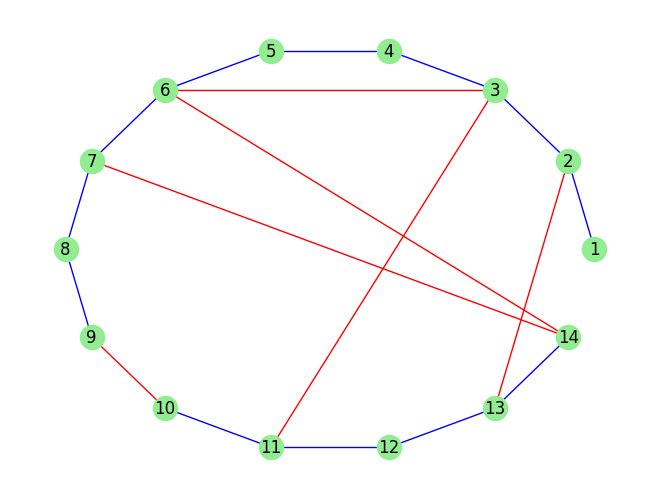

In [13]:
import networkx as nx

print(transitions)
# Permet d'afficher les transitions entre les différents clusters de la musique sous forme de graphe circulaire
newTab = []

for i in range(len(transitions)-1):
    newTab.append([transitions[i][1],transitions[i+1][0]])
        

nbClusters = len(limits)
G = nx.Graph()

for i in range(nbClusters):
    G.add_node(i+1)

for i in range(nbClusters-1):
    G.add_edge(i+1,i+2,color="b",weight=2)

for elt in newTab:
    G.add_edge(elt[0],elt[1],color="r",weight=2)

graph = nx.circular_layout(G)

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]

nx.draw(G,graph,edge_color=colors,node_color="lightgreen",with_labels=True)
plt.show()


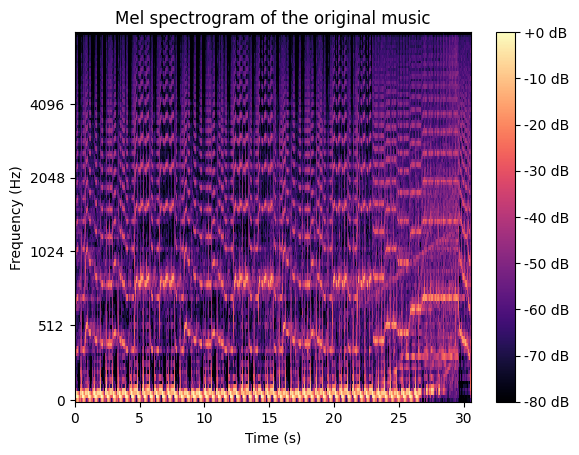

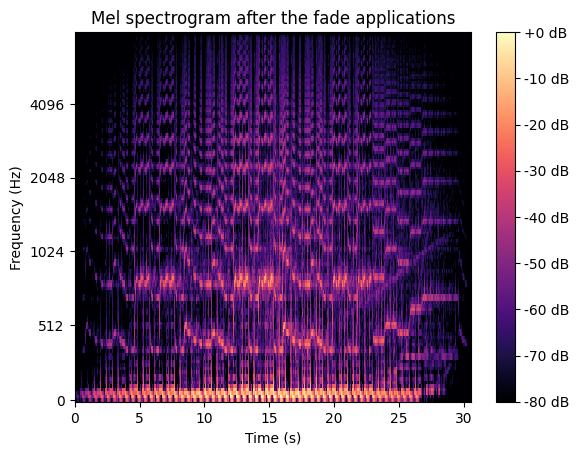

In [14]:
# FONCTIONS POUR APPLIQUER LES FADE-IN / FADE-OUT

def apply_fadeout(audio, sr, duration=3.0):
    length = int(duration*sr)

    end = audio.shape[0]
    start = end - length

    fade_curve = np.linspace(1.0, 0.0, length)

    audio[start:end,0] = audio[start:end,0] * fade_curve
    audio[start:end,1] = audio[start:end,1] * fade_curve

def apply_fadein(audio, sr, duration=3.0):
    length = int(duration*sr)
    start = 0
    end = start + length

    fade_curve = np.linspace(0.0, 1.0, length)

    audio[start:end,0] = audio[start:end,0] * fade_curve
    audio[start:end,1] = audio[start:end,1] * fade_curve

if shutil.os.path.exists("test/fades/result.wav"):
    shutil.os.remove("test/fades/result.wav")

y_fade, sr_fade = librosa.load("test/fades/original.wav")
S_fade = librosa.feature.melspectrogram(y=y_fade, sr=sr_fade, power=3.0)

librosa.display.specshow(librosa.power_to_db(S_fade, ref=np.max),x_axis='time', y_axis='mel', fmax=8000)
plt.title('Mel spectrogram of the original music')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(format='%+2.0f dB')

plt.show()

test,sampleR = sf.read("test/fades/original.wav")
# print(test.shape,sampleR)
# 
out = test.copy()
apply_fadein(out,sampleR,15.0)
apply_fadeout(out,sampleR,15.0)
sf.write("test/fades/result.wav",out,sampleR,'PCM_16')

y_result, sr_result = librosa.load("test/fades/result.wav")
S_result = librosa.feature.melspectrogram(y=y_result, sr=sr_result, power=3.0)

librosa.display.specshow(librosa.power_to_db(S_result, ref=np.max),x_axis='time', y_axis='mel', fmax=8000)
plt.title('Mel spectrogram after the fade applications')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(format='%+2.0f dB')

plt.show()

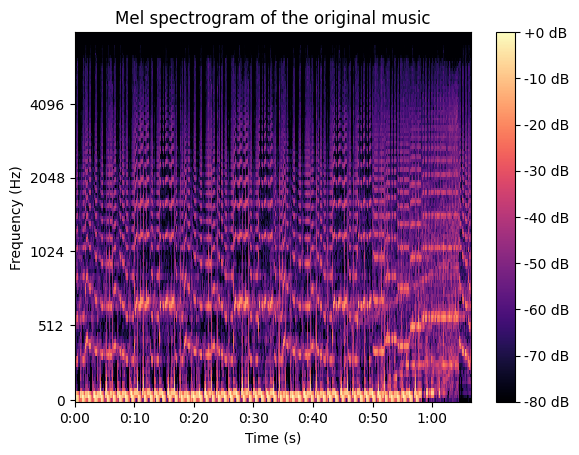

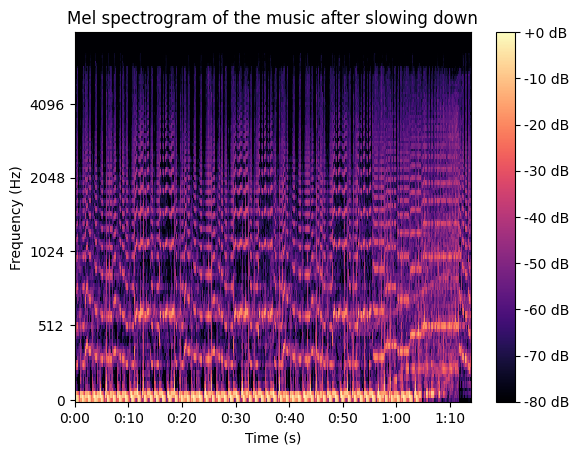

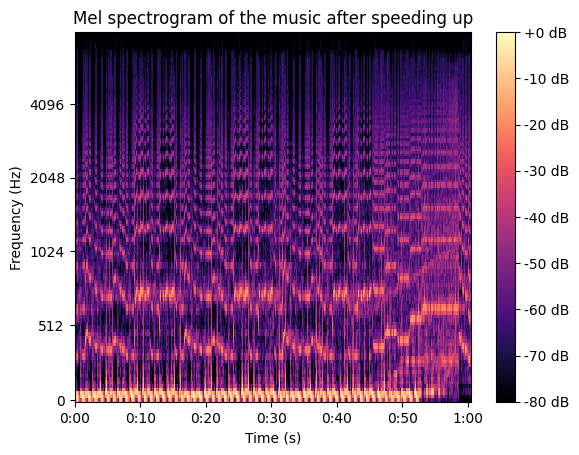

In [15]:
## FONCTIONS POUR ACCELERER / DECCELERER UN FICHIER AUDIO
def change_tempo(audio, sr, factor=1.0):
    new_audio = []

    for i in range(audio.shape[0]):
        new_audio.append(librosa.resample(audio[i, :], orig_sr=sr, target_sr=sr/factor))

    new_audio = np.array(new_audio)

    return new_audio

if shutil.os.path.exists("test/changing_speed/result_slow.wav"):
    shutil.os.remove("test/changing_speed/result_slow.wav")
if shutil.os.path.exists("test/changing_speed/result_fast.wav"):
    shutil.os.remove("test/changing_speed/result_fast.wav")

test,sampleR = librosa.load("test/changing_speed/original.wav", sr=None, mono=False)

out = change_tempo(test,sampleR,0.9)
sf.write("test/changing_speed/result_slow.wav",out.T,sampleR)

out = change_tempo(test,sampleR,1.1)
sf.write("test/changing_speed/result_fast.wav",out.T,sampleR)

test = librosa.to_mono(test)
S_normal = librosa.feature.melspectrogram(y=test, sr=sampleR, power=3.0)

# Affichage des mel-spectrogrammes pour chaque vitesse de musique différente
librosa.display.specshow(librosa.power_to_db(S_normal, ref=np.max),x_axis='time', y_axis='mel', fmax=8000)
plt.title('Mel spectrogram of the original music')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(format='%+2.0f dB')
plt.show()

test_slow,sampleR = librosa.load("test/changing_speed/result_slow.wav", sr=None, mono=False)
test_slow = librosa.to_mono(test_slow)
S_slow = librosa.feature.melspectrogram(y=test_slow, sr=sampleR, power=3.0)

librosa.display.specshow(librosa.power_to_db(S_slow, ref=np.max),x_axis='time', y_axis='mel', fmax=8000)
plt.title('Mel spectrogram of the music after slowing down')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(format='%+2.0f dB')
plt.show()

test_fast,sampleR = librosa.load("test/changing_speed/result_fast.wav", sr=None, mono=False)
test_fast = librosa.to_mono(test_fast)
S_fast = librosa.feature.melspectrogram(y=test_fast, sr=sampleR, power=3.0)

librosa.display.specshow(librosa.power_to_db(S_fast, ref=np.max),x_axis='time', y_axis='mel', fmax=8000)
plt.title('Mel spectrogram of the music after speeding up')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(format='%+2.0f dB')
plt.show()

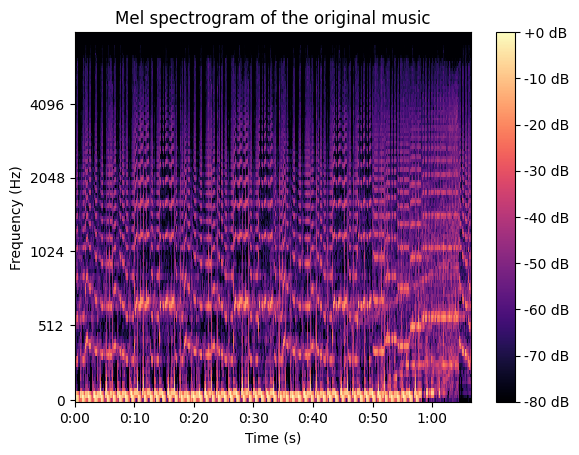

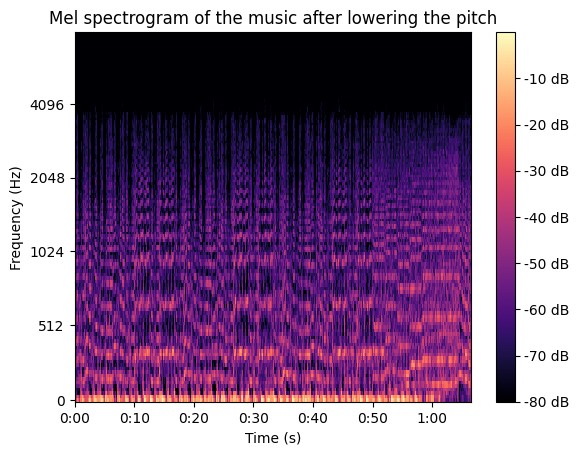

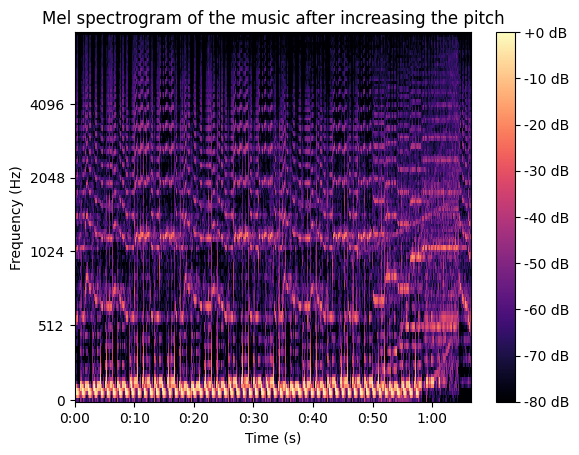

In [16]:
## FONCTIONS PITCH SHIFTING
def change_pitch(audio, sr, shift):
    newAudio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=shift)

    return newAudio

if shutil.os.path.exists("test/pitch_shifting/lower_pitch.wav"):
    shutil.os.remove("test/pitch_shifting/lower_pitch.wav")
if shutil.os.path.exists("test/pitch_shifting/higher_pitch.wav"):
    shutil.os.remove("test/pitch_shifting/higher_pitch.wav")

test,spr = librosa.load("test/pitch_shifting/original.wav", sr=None, mono=False)

out = change_pitch(test,spr,-12)
sf.write("test/pitch_shifting/lower_pitch.wav",out.T,spr)

out = change_pitch(test,spr,12)
sf.write("test/pitch_shifting/higher_pitch.wav",out.T,spr)

test = librosa.to_mono(test)
S_normal = librosa.feature.melspectrogram(y=test, sr=spr, power=3.0)

# Affichage des mel-spectrogrammes pour chaque tonalité différente
librosa.display.specshow(librosa.power_to_db(S_normal, ref=np.max),x_axis='time', y_axis='mel', fmax=8000)
plt.title('Mel spectrogram of the original music')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(format='%+2.0f dB')
plt.show()

test_low,spr = librosa.load("test/pitch_shifting/lower_pitch.wav", sr=None, mono=False)
test_low = librosa.to_mono(test_low)
S_low = librosa.feature.melspectrogram(y=test_low, sr=spr, power=3.0)

librosa.display.specshow(librosa.power_to_db(S_low, ref=np.max),x_axis='time', y_axis='mel', fmax=8000)
plt.title('Mel spectrogram of the music after lowering the pitch')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(format='%+2.0f dB')
plt.show()

test_high,spr = librosa.load("test/pitch_shifting/higher_pitch.wav", sr=None, mono=False)
test_high = librosa.to_mono(test_high)
S_high = librosa.feature.melspectrogram(y=test_high, sr=spr, power=3.0)

librosa.display.specshow(librosa.power_to_db(S_high, ref=np.max),x_axis='time', y_axis='mel', fmax=8000)
plt.title('Mel spectrogram of the music after increasing the pitch')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(format='%+2.0f dB')
plt.show()